주제: 전이학습과 텐서플로우라이트로 변환  
이 파일에서는 아래와 같은 주요 기능이 수행됩니다. 
1. tensorflow 데이터세트를 선택합니다. 
2. (in Kaggle) 기존에 잘 학습된 feature vector model을 나의 모델에 애드온 합니다. 
3. 데이터 트레이닝 데이터 세트를 훈련시켜 모델을 완성합니다. 
4. 트레이닝을 마친 최종 모델을 최적화를 거쳐 텐서플로우 라이트로 변환합니다. 
6. 테스트 데이터로 최종 검증 결과를 확인합니다. 
-------------
tensorflow dataset(https://www.tensorflow.org/datasets?hl=ko)으로 kaggle(https://www.kaggle.com/)에 있는 feature vector model을 적용시켜 테스트한 결과 입니다. 
https://www.kaggle.com/code/tuningkiwi/transferlearning0131/notebook 에서 최종 버전의 코드를 확인할 수 있습니다.  

In [ ]:
#colab에서 돌린것이라 명령어 앞에 !을 붙임 
!python -m  pip install tflite-runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.9 MB/s eta 0:00:00


Selected model: mobilenet_v2_tf2_pre_fv_v4 : https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4
Input size (224, 224), Output feature vector size 1280
tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_example

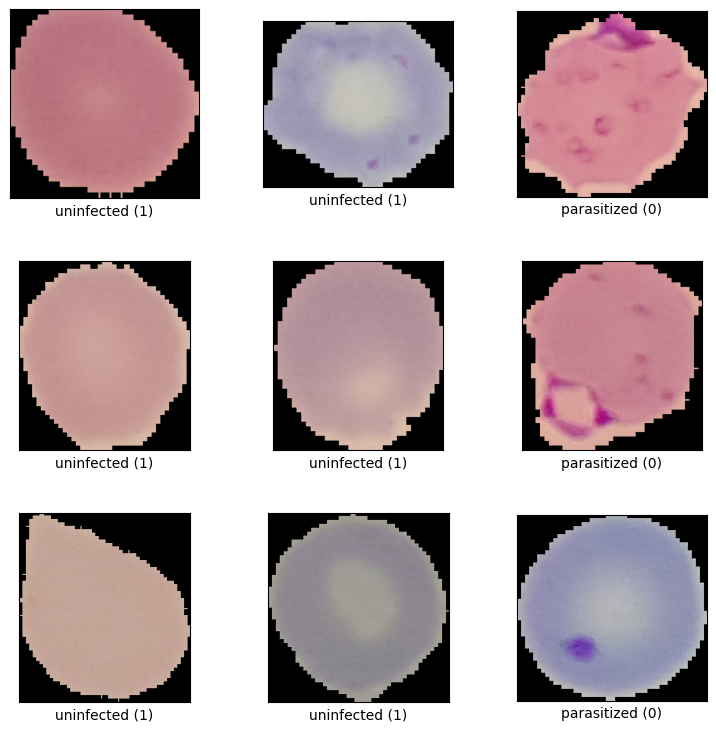

Epoch 1/5
689/689 [==============================] - 43s 46ms/step - loss: 0.2020 - accuracy: 0.9257 - val_loss: 0.1601 - val_accuracy: 0.9380
Epoch 2/5
689/689 [==============================] - 42s 56ms/step - loss: 0.1651 - accuracy: 0.9423 - val_loss: 0.1473 - val_accuracy: 0.9448
Epoch 3/5
689/689 [==============================] - 47s 60ms/step - loss: 0.1523 - accuracy: 0.9462 - val_loss: 0.1455 - val_accuracy: 0.9470
Epoch 4/5
689/689 [==============================] - 37s 47ms/step - loss: 0.1468 - accuracy: 0.9491 - val_loss: 0.1515 - val_accuracy: 0.9448
Epoch 5/5
689/689 [==============================] - 37s 49ms/step - loss: 0.1420 - accuracy: 0.9493 - val_loss: 0.1446 - val_accuracy: 0.9478
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 

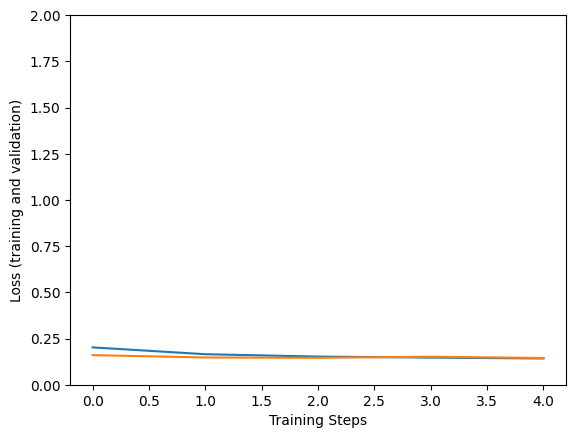

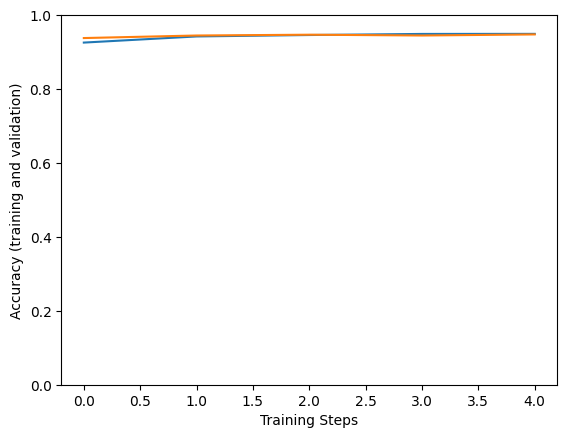

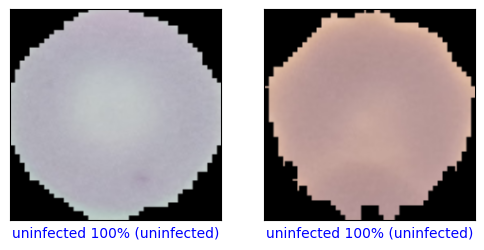

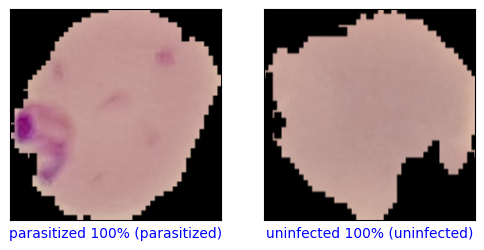

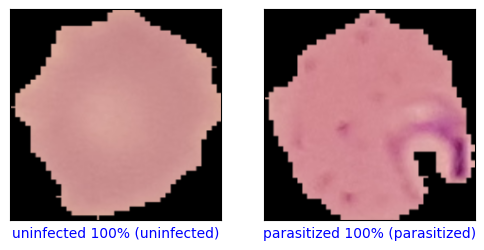

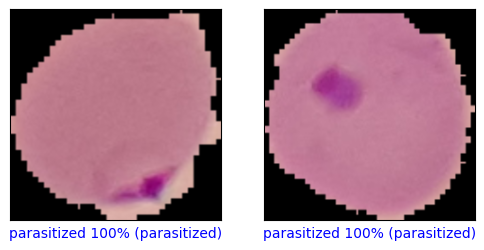

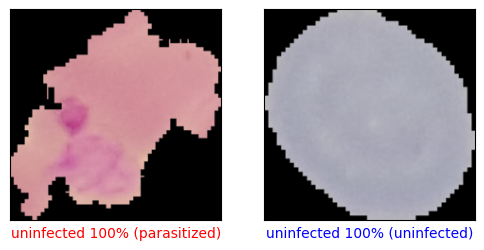

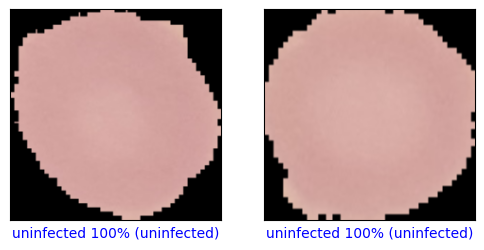

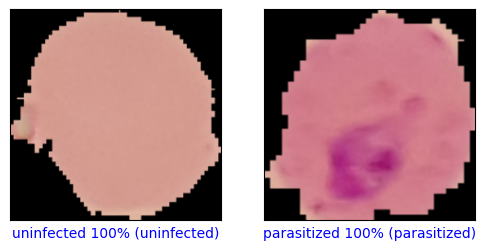

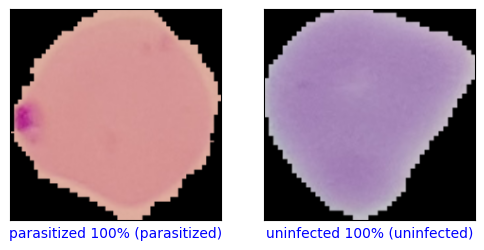

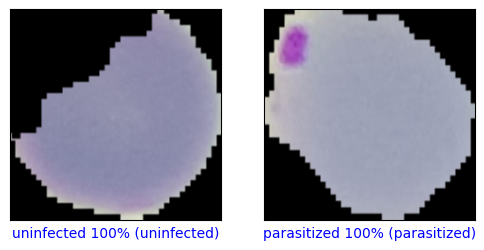

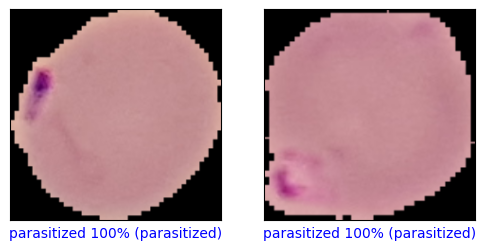

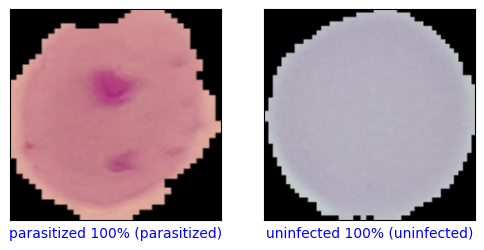

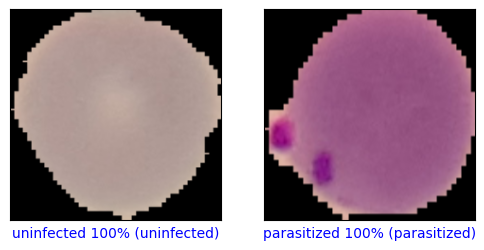

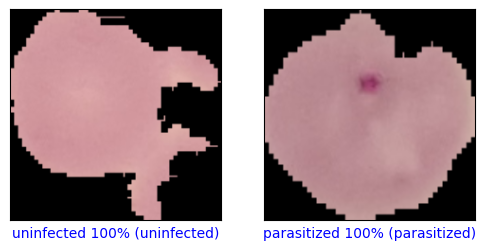

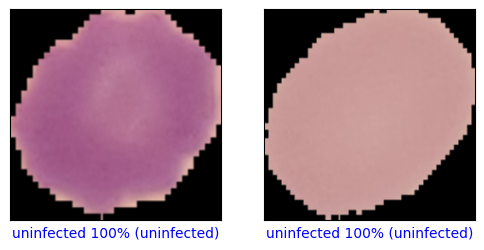

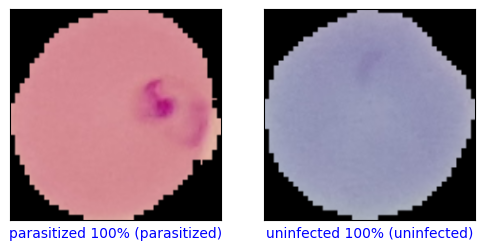

In [ ]:
###############################
## 말라리아 malaria
#['parasitized', 'uninfected']
#mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tflite_runtime.interpreter as tflite

###########전이학습을 위한 이미지 특성 벡터 생성하는 모델 선택하기##########
handle_base_name = "mobilenet_v2_140_224_v2" # @param ['mobilenet_v2_tf2_pre_fv_v4', 'mobilenet_v2_140_224_v2', 'effNet_v2_1k_b0_fv_v2']

#링크
handle_base_map = {
  "mobilenet_v2_tf2_pre_fv_v4": "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4",
  "mobilenet_v2_140_224_v2": "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/140-224-feature-vector/versions/2",
  "effNet_v2_1k_b0_fv_v2": "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-feature-vector/versions/2",
}

#인풋 이미지 사이즈 크기
handle_base_image_size_map = {
  "mobilenet_v2_tf2_pre_fv_v4": 224,
  "mobilenet_v2_140_224_v2": 224,
  "effNet_v2_1k_b0_fv_v2": 224,
}

#아웃풋 FEATURE VECTOR SIZE
handle_base_output_map ={
  "mobilenet_v2_tf2_pre_fv_v4":1280,
  "mobilenet_v2_140_224_v2": 1792,
  "effNet_v2_1k_b0_fv_v2": 1280

}

model_handle = handle_base_map.get(handle_base_name)
pixels = handle_base_image_size_map.get(handle_base_name, 224) #(2번째 파라미터는 해당 모델이 없을 시, 디폴트값
feature_vector_size = handle_base_output_map.get(handle_base_name)
IMAGE_SIZE = (pixels, pixels)

print(f"Selected model: {handle_base_name} : {model_handle}")
print(f"Input size {IMAGE_SIZE}, Output feature vector size {feature_vector_size}")

feature_extractor = hub.KerasLayer(
    model_handle,
    input_shape = IMAGE_SIZE +(3,),
    output_shape = [feature_vector_size],
    trainable = False
)
BATCH_SIZE = 32

##########데이터세트 설정하기 (모델에 맞게 이미지 조정)##########

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'malaria',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)

print(metadata)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
class_names =metadata.features['label'].names
print(class_names)

#train data 대표 이미지 9개 보여주기
fig = tfds.show_examples(raw_train, metadata)

train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

##########모델 정의하기#############

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation ='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 5,
    validation_data = validation_batches
).history

model.summary()

#트레이닝 결과 그래프 보여주기
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"],label='loss')
plt.plot(hist["val_loss"],label='val_loss')
plt.legend(loc='upper right')

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"],label='accu')
plt.plot(hist["val_accuracy"],label='val_acc')
plt.legend(loc='lower right')

#학습된 모델 saved_model로 저장하기
_SAVED_MODEL = "/content/drive/MyDrive/INTEL_PYTHON/malaria_saved_model"
tf.saved_model.save(model, _SAVED_MODEL)

# tensoflow Lite 파일 생성하기
converter = tf.lite.TFLiteConverter.from_saved_model(_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT] #Dynamic Range Quantization
tflite_model = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/malaria_converted_model.tflite'

#with open(…) as f 에서 f는 open(…)함수가 리턴한 file object.
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)


###########################
## 라즈베리 파이에서 실행할 추론 코드
###########################

#인터프리터 생성
interpreter = tflite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/malaria_converted_model.tflite')

#텐서 할당
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

#input, output 텐서 정보 확인
input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)

predictions =[]

# print(input_index)
# print(output_index)

#추론하기
predictions =[]
test_labels, test_imgs = [],[]
for img, label in test_batches.take(100):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


#추론 결과 점수로 확인하기
score  = 0
for item in range(0,100):
    prediction = np.argmax(predictions[item])
    label = test_labels[item]
    if prediction == label:
        score = score +1

print("100개 중 맞은 예측 수: "+ str(score))

def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = tf.squeeze(img)
    plt.imshow(img)

    predicted_label = np.argmax(predictions_array[index])
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{class_names[predicted_label]}
    {100*np.max(predictions_array):2.0f}%\n ({class_names[true_label]})",
                                    color=color)

for index in range(0,99):
    match (index%9):
        case (0):
            plt.figure(figsize=(9,9))
            plt.subplot(331)
        case (1):
            plt.subplot(332)
        case (2):
            plt.subplot(333)
        case (3):
            plt.subplot(334)
        case (4):
            plt.subplot(335)
        case (5):
            plt.subplot(336)
        case (6):
            plt.subplot(337)
        case (7):
            plt.subplot(338)
        case (8):
            plt.subplot(339)
            plot_image(index, predictions, test_labels, test_imgs)
            plt.suptitle('Figure{}'.format(int(index/8)))
            #plt.savefig('resultImg/result{}.png'.format(int(i/8)))
            continue
    plot_image(index, predictions, test_labels, test_imgs)




In [ ]:
###############################
## eurosat
#mobilenet-v2/frameworks/TensorFlow2/variations/140-224-feature-vector/versions/2
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tflite_runtime.interpreter as tflite


###########전이학습을 위한 이미지 특성 벡터 생성하는 모델 선택하기##########
handle_base_name = "effNet_v2_1k_b0_fv_v2" # @param ['mobilenet_v2_tf2_pre_fv_v4', 'mobilenet_v2_140_224_v2', 'effNet_v2_1k_b0_fv_v2']

#링크
handle_base_map = {
  "mobilenet_v2_tf2_pre_fv_v4": "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4",
  "mobilenet_v2_140_224_v2": "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/140-224-feature-vector/versions/2",
  "effNet_v2_1k_b0_fv_v2": "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-feature-vector/versions/2",
}

#인풋 이미지 사이즈 크기
handle_base_image_size_map = {
  "mobilenet_v2_tf2_pre_fv_v4": 224,
  "mobilenet_v2_140_224_v2": 224,
  "effNet_v2_1k_b0_fv_v2": 224,
}

#아웃풋 FEATURE VECTOR SIZE
handle_base_output_map ={
  "mobilenet_v2_tf2_pre_fv_v4":1280,
  "mobilenet_v2_140_224_v2": 1792,
  "effNet_v2_1k_b0_fv_v2": 1280

}

model_handle = handle_base_map.get(handle_base_name)
pixels = handle_base_image_size_map.get(handle_base_name, 224) #(2번째 파라미터는 해당 모델이 없을 시, 디폴트값
feature_vector_size = handle_base_output_map.get(handle_base_name)
IMAGE_SIZE = (pixels, pixels)

print(f"Selected model: {handle_base_name} : {model_handle}")
print(f"Input size {IMAGE_SIZE}, Output feature vector size {feature_vector_size}")

feature_extractor = hub.KerasLayer(
    model_handle,
    input_shape = IMAGE_SIZE +(3,),
    output_shape = [feature_vector_size],
    trainable = False
)
BATCH_SIZE = 30

##########데이터세트 설정하기 (모델에 맞게 이미지 조정)##########
#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'eurosat',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)

print(metadata)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
class_names =metadata.features['label'].names
print(class_names)

fig = tfds.show_examples(raw_train, metadata)

train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

##########모델 정의하기#############

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation ='softmax')
])

model.compile(
    optimizer='adam', #sgd 사용하지 말것
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 10,
    validation_data = validation_batches
).history

model.summary()

#트레이닝 결과 그래프 보여주기
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"],label='loss')
plt.plot(hist["val_loss"],label='val_loss')
plt.legend(loc='upper right')


plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"],label='accu')
plt.plot(hist["val_accuracy"],label='val_acc')
plt.legend(loc='lower right')

#학습된 모델 저장하기
_SAVED_MODEL = "/content/drive/MyDrive/INTEL_PYTHON/eurosat140_224_saved_model"
tf.saved_model.save(model, _SAVED_MODEL)

#tensoflow lite로 변환하기
converter = tf.lite.TFLiteConverter.from_saved_model(_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT] #최적화
tflite_model = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/eurosat140_224_converted_model.tflite'

#with open(…) as f 에서 f는 open(…)함수가 리턴한 file object.
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)


###########################
## 라즈베리 파이에서 실행할 추론 코드
###########################

interpreter = tflite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/eurosat140_224_converted_model.tflite')

#텐서 할당
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

#input, output 텐서 정보 확인
input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)

predictions =[]

# print(input_index)
# print(output_index)

#테스트 데이터로 추론하기
predictions =[]
test_labels, test_imgs = [],[]
for img, label in test_batches.take(100):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


#추론 결과 확인하기
score  = 0
for item in range(0,100):
    prediction = np.argmax(predictions[item])
    label = test_labels[item]
    if prediction == label:
        score = score +1

print("100개 중 맞은 예측 수: "+ str(score))

def plot_image(index, predictions_array, true_label, img):
    true_label, img = true_label[index], img[index]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = tf.squeeze(img)
    plt.imshow(img)

    predicted_label = np.argmax(predictions_array[index])
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}%, ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)


for index in range(0,99):
    match (index%9):
        case (0):
            plt.figure(figsize=(9,9))
            plt.subplot(331)
        case (1):
            plt.subplot(332)
        case (2):
            plt.subplot(333)
        case (3):
            plt.subplot(334)
        case (4):
            plt.subplot(335)
        case (5):
            plt.subplot(336)
        case (6):
            plt.subplot(337)
        case (7):
            plt.subplot(338)
        case (8):
            plt.subplot(339)
            plot_image(index, predictions, test_labels, test_imgs)
            plt.suptitle('Figure{}'.format(int(index/8)))
            #plt.savefig('resultImg/result{}.png'.format(int(i/8)))
            continue
    plot_image(index, predictions, test_labels, test_imgs)





Output hidden; open in https://colab.research.google.com to view.

In [ ]:
###############################
# cats vs dog
# EFFICIENT NET
# https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-feature-vector/versions/2
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tflite_runtime.interpreter as tflite


###########전이학습을 위한 이미지 특성 벡터 생성하는 모델 선택하기##########
handle_base_name = "mobilenet_v2_tf2_pre_fv_v4" # @param ['mobilenet_v2_tf2_pre_fv_v4', 'mobilenet_v2_140_224_v2', 'effNet_v2_1k_b0_fv_v2']

#링크
handle_base_map = {
  "mobilenet_v2_tf2_pre_fv_v4": "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4",
  "mobilenet_v2_140_224_v2": "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/140-224-feature-vector/versions/2",
  "effNet_v2_1k_b0_fv_v2": "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-feature-vector/versions/2",
}

#인풋 이미지 사이즈 크기
handle_base_image_size_map = {
  "mobilenet_v2_tf2_pre_fv_v4": 224,
  "mobilenet_v2_140_224_v2": 224,
  "effNet_v2_1k_b0_fv_v2": 224,
}

#아웃풋 FEATURE VECTOR SIZE
handle_base_output_map ={
  "mobilenet_v2_tf2_pre_fv_v4":1280,
  "mobilenet_v2_140_224_v2": 1792,
  "effNet_v2_1k_b0_fv_v2": 1280

}

model_handle = handle_base_map.get(handle_base_name)
pixels = handle_base_image_size_map.get(handle_base_name, 224) #(2번째 파라미터는 해당 모델이 없을 시, 디폴트값
feature_vector_size = handle_base_output_map.get(handle_base_name)
IMAGE_SIZE = (pixels, pixels)

print(f"Selected model: {handle_base_name} : {model_handle}")
print(f"Input size {IMAGE_SIZE}, Output feature vector size {feature_vector_size}")

feature_extractor = hub.KerasLayer(
    model_handle,
    input_shape = IMAGE_SIZE +(3,),
    output_shape = [feature_vector_size],
    trainable = False
)
BATCH_SIZE = 32


##########데이터세트 설정하기 (모델에 맞게 이미지 조정)##########
#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)

print(metadata)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
class_names = metadata.features['label'].names

train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)


##########모델 정의하기#############
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation ='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 5,
    validation_data = validation_batches
).history

model.summary()

#트레이닝 결과 그래프 보여주기
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"],label='loss')
plt.plot(hist["val_loss"],label='val_loss')
plt.legend(loc='upper right')

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"],label='accu')
plt.plot(hist["val_accuracy"],label='val_acc')
plt.legend(loc='lower right')

#학습된 모델 저장하기
_SAVED_MODEL = "/content/drive/MyDrive/INTEL_PYTHON/effNET_exp_saved_model"
tf.saved_model.save(model, _SAVED_MODEL)

#tensoflow lite로 변환하기
converter = tf.lite.TFLiteConverter.from_saved_model(_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/effNET_converted_model.tflite'

#with open(…) as f 에서 f는 open(…)함수가 리턴한 file object.
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

###########################
## 라즈베리 파이에서 실행할 추론 코드
###########################

#모델 로드
interpreter = tflite.Interpreter(model_path='/content/drive/MyDrive/INTEL_PYTHON/effNET_converted_model.tflite')

#텐서 할당
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)

predictions =[]

#테스트 데이터로 추론하기
predictions =[]
test_labels, test_imgs = [],[]
for img, label in test_batches.take(100):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

#추론 결과 확인하기
score  = 0
for item in range(0,100):
    prediction = np.argmax(predictions[item])
    label = test_labels[item]
    if prediction == label:
        score = score +1

print("100개 중 맞은 예측 수: "+ str(score))

def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = tf.squeeze(img)
    plt.imshow(img)

    predicted_label = np.argmax(predictions_array[i])
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)


for index in range(0,99):
    match (index%9):
        case (0):
            plt.figure(figsize=(9,9))
            plt.subplot(331)
        case (1):
            plt.subplot(332)
        case (2):
            plt.subplot(333)
        case (3):
            plt.subplot(334)
        case (4):
            plt.subplot(335)
        case (5):
            plt.subplot(336)
        case (6):
            plt.subplot(337)
        case (7):
            plt.subplot(338)
        case (8):
            plt.subplot(339)
            plot_image(index, predictions, test_labels, test_imgs)
            plt.suptitle('Figure{}'.format(int(index/8)))
            #plt.savefig('resultImg/result{}.png'.format(int(i/8)))
            continue
    plot_image(index, predictions, test_labels, test_imgs)
# for index in range(0,99):
#     if index%2 == 0 :
#       plt.figure(figsize = (6,3))
#       plt.subplot(121)
#     elif index %2 ==1 :
#       plt.subplot(122)

#     plot_image(index, predictions, test_labels, test_imgs)
#       #imgFile = 'resultImg/result{}.png'.format(index)
#       #plt.savefig(imgFile)




Selected model: effNet_v2_1k_b0_fv_v2 : https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-feature-vector/versions/2
Input size (224, 224), Output feature vector size 1280


KeyboardInterrupt: 

# mobileNet v2 _preview_feature_vector _version4  결과

Epoch 5/5
582/582 [==============================] - 47s 68ms/step -
loss: 0.0188 - accuracy: 0.9937 -
val_loss: 0.0514 - val_accuracy: 0.9824
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
=================================================================
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)